<a href="https://colab.research.google.com/github/IshimotoTakara/Classification-of-Japanese-Documents-by-BERT/blob/main/Document_Classification_by_BERT_JP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTによる日本語文書分類
livedoorニュースコーパスを用いた多クラス分類タスクを日本語BERTモデルにより実装した。

* 使用した事前学習済みモデル
    
    **東北大学の乾・鈴木研究室の日本語事前学習済みモデル**

* データセットの分割方法
    
    学習データ:検証データ:テストデータ = 8:1:1

* 学習パラメタ

    Dropout率：0.4

    バッチサイズ：16

    エポック数：5

    学習率：2e-5
* 結果

    **Accuracy：0.921**

In [1]:
# 環境確認
import torch
import sys
print("Pythonのバージョン：",sys.version)
print("PyTorchのバージョン：", torch.__version__)
print("使用しているGPUの確認")
!nvidia-smi

Pythonのバージョン： 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
PyTorchのバージョン： 1.12.1+cu113
使用しているGPUの確認
Wed Nov 30 05:59:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----

# データの準備

## データのダウンロード
データセット：[livedoorニュースコーパス](https://www.rondhuit.com/download.html)

In [ ]:
# livedoorニュースコーパスのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar zxvf ldcc-20140209.tar.gz

# 整形結果格納用ファイル作成
!echo -e "filename\tarticle"$(for category in $(basename -a `find ./text -type d` | grep -v text | sort); do echo -n "\t"; echo -n $category; done) > ./text/livedoor.tsv

# カテゴリごとに格納
!for filename in `basename -a ./text/dokujo-tsushin/dokujo-tsushin-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/dokujo-tsushin/$filename`; echo -e "\t1\t0\t0\t0\t0\t0\t0\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/it-life-hack/it-life-hack-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/it-life-hack/$filename`; echo -e "\t0\t1\t0\t0\t0\t0\t0\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/kaden-channel/kaden-channel-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/kaden-channel/$filename`; echo -e "\t0\t0\t1\t0\t0\t0\t0\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/livedoor-homme/livedoor-homme-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/livedoor-homme/$filename`; echo -e "\t0\t0\t0\t1\t0\t0\t0\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/movie-enter/movie-enter-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/movie-enter/$filename`; echo -e "\t0\t0\t0\t0\t1\t0\t0\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/peachy/peachy-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/peachy/$filename`; echo -e "\t0\t0\t0\t0\t0\t1\t0\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/smax/smax-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/smax/$filename`; echo -e "\t0\t0\t0\t0\t0\t0\t1\t0\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/sports-watch/sports-watch-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/sports-watch/$filename`; echo -e "\t0\t0\t0\t0\t0\t0\t0\t1\t0"; done >> ./text/livedoor.tsv
!for filename in `basename -a ./text/topic-news/topic-news-*`; do echo -n "$filename"; echo -ne "\t"; echo -n `sed -e '1,3d' ./text/topic-news/$filename`; echo -e "\t0\t0\t0\t0\t0\t0\t0\t0\t1"; done >> ./text/livedoor.tsv

Streaming output truncated to the last 5000 lines.
text/smax/smax-6833065.txt
text/smax/smax-6833494.txt
text/smax/smax-6833579.txt
text/smax/smax-6834422.txt
text/smax/smax-6834562.txt
text/smax/smax-6834765.txt
text/smax/smax-6834990.txt
text/smax/smax-6835318.txt
text/smax/smax-6838218.txt
text/smax/smax-6838260.txt
text/smax/smax-6838332.txt
text/smax/smax-6838453.txt
text/smax/smax-6838514.txt
text/smax/smax-6838627.txt
text/smax/smax-6838702.txt
text/smax/smax-6842164.txt
text/smax/smax-6842219.txt
text/smax/smax-6842269.txt
text/smax/smax-6842402.txt
text/smax/smax-6842629.txt
text/smax/smax-6842882.txt
text/smax/smax-6843206.txt
text/smax/smax-6845003.txt
text/smax/smax-6847081.txt
text/smax/smax-6849018.txt
text/smax/smax-6850114.txt
text/smax/smax-6850391.txt
text/smax/smax-6850789.txt
text/smax/smax-6851590.txt
text/smax/smax-6851919.txt
text/smax/smax-6853063.txt
text/smax/smax-6853346.txt
text/smax/smax-6853751.txt
text/smax/smax-6854198.txt
text/smax/smax-6855347.txt
text

In [ ]:
# 確認
!head -10 ./text/livedoor.tsv

filename	article	dokujo-tsushin	it-life-hack	kaden-channel	livedoor-homme	movie-enter	peachy	smax	sports-watch	topic-news
dokujo-tsushin-4778030.txt	　もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？　さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。 　「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」 　さてそんなとき、独女はどう対応したらいいか？ 　最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。 　「一晩で3人位の人が添削してくれましたよ。ちなみに自分以外にもそういう人はたくさんいて、その相談サイトには同じように添削をお願いする投稿がいっぱいありました」（由利さん）。ためしに教えてもらったそのサイトをみてみると、確かに「結婚式のスピーチの添削お願いします」という投稿が1000件を超えるくらいあった。めでたい結婚式の影でこんなネットコミュニティがあったとは知らなかった。 　しかし「事前にお願いされるスピーチなら準備ができるしまだいいですよ。一番嫌なのは何といってもサプライズスピーチ！」と語るのは昨年だけで10万以上お祝いにかかったというお祝い貧乏独女の薫さん（35歳） 　「私は基本的に人前で話すのが苦手なんですよ。だからいきなり指名されるとしどろもどろになって何もいえなくなる。そうすると自己嫌悪に陥って終わった後でもまったく楽しめなくなりますね」 　 　サプライズスピーチのメリットとしては、準備していない状態なので、フ

## データフレーム化して、Train-Validation-Test分割

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# データの読込
df = pd.read_csv('./text/livedoor.tsv', sep='\t')

# データの分割
categories = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df[categories])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test[categories])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 事例数の確認
table = [['train'] + [train[category].sum() for category in categories],
         ['valid'] + [valid[category].sum() for category in categories],
         ['test'] + [test[category].sum() for category in categories]]
headers = ['data'] + categories
print(tabulate(table, headers, tablefmt='grid'))

+--------+------------------+----------------+-----------------+------------------+---------------+----------+--------+----------------+--------------+
| data   |   dokujo-tsushin |   it-life-hack |   kaden-channel |   livedoor-homme |   movie-enter |   peachy |   smax |   sports-watch |   topic-news |
+========+==================+================+=================+==================+===============+==========+========+================+==============+
| train  |              696 |            696 |             691 |              409 |           696 |      673 |    696 |            720 |          616 |
+--------+------------------+----------------+-----------------+------------------+---------------+----------+--------+----------------+--------------+
| valid  |               87 |             87 |              87 |               51 |            87 |       84 |     87 |             90 |           77 |
+--------+------------------+----------------+-----------------+------------------+-----

# 学習

## 準備
*   BERTモデルを利用するためにtransformersライブラリをインストール（transformersを通じて、BERT以外にも多くの事前学習済みモデルを短いコードで非常に簡単に利用することができる）
*   モデルの学習と評価に必要なライブラリをインポート




In [ ]:
!pip install transformers["ja"]
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.7 MB/s 
     |████████████████████████████████| 163 kB 68.0 MB/s 
     |████████████████████████████████| 7.6 MB 56.6 MB/s 
     |████████████████████████████████| 2.2 MB 66.5 MB/s 
     |████████████████████████████████| 13.4 MB 52.8 MB/s 
     |████████████████████████████████| 583 kB 65.6 MB/s 
     |████████████████████████████████| 47.4 MB 287 kB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556722 sha256=f989b6c4480ae948c947467ddf1a7bdd4f5664ea6ec2634cd53f271a14fccb9f
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
  Created wheel for sudachidict-core: filename=SudachiDict_core-20221021-py3-none-any.whl size=71574781 sha256=cfb743c71b5274733cb268a8db0c2387cf2fbf106cd86a7533729e3b14163638
  S

In [ ]:
import numpy as np
from transformers import AutoModel, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import cuda
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

## 事前学習済みモデルの指定
**bert-base-japanese-whole-word-masking**

東北大学の乾・鈴木研究室の日本語事前学習済みモデル

In [ ]:
pretrained = 'cl-tohoku/bert-base-japanese-whole-word-masking'

## Datasetの作成
Datasetとは、PyTorchでよく利用される、特徴ベクトルとラベルベクトルを合わせて保持するめのクラス

In [ ]:
# Datasetの定義
class Dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      padding='max_length'
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [ ]:
# 最大系列長の指定
# 本来BERTでは512まで指定可能だが、メモリの制約上256で指定している。
MAX_LEN = 256 # これより長い文は切られ、短い文はパディングされることによりこの長さに揃えられる

# tokenizerの取得
tokenizer = AutoTokenizer.from_pretrained(pretrained)

# Datasetの作成
dataset_train = Dataset(train['article'], train[categories].values, tokenizer, MAX_LEN)
dataset_valid = Dataset(valid['article'], valid[categories].values, tokenizer, MAX_LEN)
dataset_test = Dataset(test['article'], test[categories].values, tokenizer, MAX_LEN)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

ids: tensor([    2,  1953,    14,  7454,   969,     5,  3596,    18,    15, 29105,
        28475,     7,  1755,  5781,   440,    26,    20,    16,    33,   757,
        29517,     5,   993,    12,    31,     6,   109, 28653, 20743,     8,
         4109,    16,  1076,  4914,    13,    15,    10,  4706, 29595,     9,
          178, 28555,   178, 28555,    26,   191, 28461,   312,     6,   704,
            7,   139,  7755,    53,    28,  3359, 28812, 28457,    16,  8009,
         4830, 15743,  1568,    14,  3904,     5, 13770,    12,  4749,   704,
        28552,    11,  6565,   972,    75,    13,  3083,    16,    28,     6,
          683, 28765,    12,     9,  2825,  2203,  4706, 29595,     5,  9462,
          135, 28524,  1964,     8,  5120,  2881,    49,  9462,   135, 28524,
         2881,     6,  8616, 28502,  4147,  3195,  8778,     5, 24064, 28485,
           11,  4722,  9531,    15,    16,    33,    53,    28,   707,  4830,
         6758,  6769,  1058,     8,   962,     6,  5233,   

## BERT分類モデルの定義

In [ ]:
class BERTClass(torch.nn.Module):
  def __init__(self, pretrained, drop_rate, otuput_size):
    super().__init__()
    self.bert = AutoModel.from_pretrained(pretrained)
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

# BERT分類モデルの学習

In [ ]:
def calculate_loss_and_accuracy(model, loader, device, criterion=None):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in tqdm(dataloader_train):
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataloader_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataloader_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

## ファインチューニングの実行

In [ ]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 9
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(pretrained, DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 369/369 [04:39<00:00,  1.32it/s]


epoch: 1, loss_train: 0.0930, accuracy_train: 0.9133, loss_valid: 0.1061, accuracy_valid: 0.8833, 403.9515sec


100%|██████████| 369/369 [04:39<00:00,  1.32it/s]


epoch: 2, loss_train: 0.0432, accuracy_train: 0.9666, loss_valid: 0.0691, accuracy_valid: 0.9091, 404.3810sec


100%|██████████| 369/369 [04:39<00:00,  1.32it/s]


epoch: 3, loss_train: 0.0235, accuracy_train: 0.9857, loss_valid: 0.0577, accuracy_valid: 0.9240, 405.0742sec


100%|██████████| 369/369 [04:39<00:00,  1.32it/s]


epoch: 4, loss_train: 0.0140, accuracy_train: 0.9925, loss_valid: 0.0560, accuracy_valid: 0.9294, 404.5785sec


100%|██████████| 369/369 [04:38<00:00,  1.32it/s]


epoch: 5, loss_train: 0.0134, accuracy_train: 0.9907, loss_valid: 0.0642, accuracy_valid: 0.9104, 403.8147sec


## 結果の確認

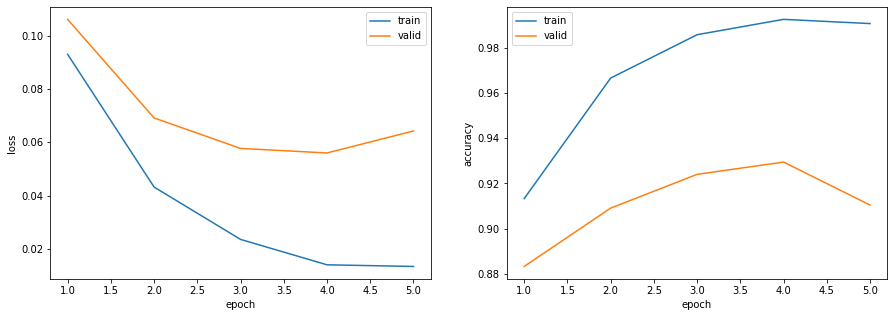

In [ ]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
# 正解率の算出
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

print(f'正解率（学習データ）：{calculate_loss_and_accuracy(model, dataloader_train, device)[1]:.3f}')
print(f'正解率（検証データ）：{calculate_loss_and_accuracy(model, dataloader_valid, device)[1]:.3f}')
print(f'正解率（テストデータ）：{calculate_loss_and_accuracy(model, dataloader_test, device)[1]:.3f}')

In [ ]:
calculate_loss_and_accuracy(model, dataloader_test, device)
